In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333, 
                            allow_growth = True, 
                            visible_device_list = "2,3")
config=tf.ConfigProto(gpu_options=gpu_options)

print(config.gpu_options.per_process_gpu_memory_fraction)
print(config.gpu_options.visible_device_list)

/Users/mustafamuratarat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.333
2,3


In [2]:
import numpy as np # import numpy for matrix calculation
np.set_printoptions(threshold=np.nan) #print all the rows and columns in numpy array

import pandas as pd
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

import tensorflow as tf
from tensorflow.python.framework import ops
import random as rd                 # import random for randomly choose training and test set
import matplotlib.pyplot as plt     # pyplot used to plot graphs
%matplotlib inline 
from sklearn.metrics import roc_curve, auc
import time
import math
import itertools
import scipy.io as spio

In [3]:
def convertDummy(y, labelNum):
    labelNum = tf.constant(labelNum)
    dummy = tf.one_hot(y, labelNum, axis=1)
    sess = tf.Session(config=config)
    dummy = sess.run(dummy)
    sess.close()
    return dummy

In [4]:
def normalize_data(data): 
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    data = ((data - data_min) / (data_max - data_min)).as_matrix()
    return data

In [5]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    colTrain=len(train.columns)
    colValidate=len(validate.columns)
    colTest=len(test.columns)
    xTrain=train.iloc[:,0:colTrain-1].as_matrix()
    yTrain=train.iloc[:,colTrain-1].as_matrix()
    xVal=validate.iloc[:,0:colValidate-1].as_matrix()
    yVal=validate.iloc[:,colValidate-1].as_matrix()
    xTest=test.iloc[:,0:colTest-1].as_matrix()
    yTest=test.iloc[:,colTest-1].as_matrix()
    return xTrain, yTrain, xVal, yVal, xTest, yTest

In [6]:
def miniBatch(x, y, batchSize):
    numObs  = x.shape[0]
    batches = []
    batchNum = math.floor(numObs / batchSize)

    for i in range(batchNum - 1):
        xBatch = x[i * batchSize:(i + 1) * batchSize, :]
        yBatch = y[i * batchSize:(i + 1) * batchSize, :]
        batches.append((xBatch, yBatch))
    xBatch = x[batchNum * batchSize:, :]
    yBatch = y[batchNum * batchSize:, :]
    batches.append((xBatch, yBatch))
    return batches

In [7]:
def initializeParam(layers):
    #First layer is named as layer0 which is input layer and last layer is output layer. 
    parameters = {}
    L = len(layers)
    for l in range(1, L):
        parameters['w' + str(l)] = tf.get_variable('w' + str(l), shape=[layers['layer' + str(l)][0], layers['layer' + str(l-1)][0]], \
        initializer=tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layers['layer' + str(l)][0], 1],  initializer=tf.zeros_initializer())
    return parameters

In [8]:
def forwardPropagate(x, parameters, activation_functions):
    #First layer is named as layer0 which is input layer and last layer is output layer. 
    L = int(len(parameters) / 2)
    a = x
    for l in range(1, L + 1):
        w = parameters['w' + str(l)]
        b = parameters['b' + str(l)]
        z = tf.add(tf.matmul(a, tf.transpose(w)), tf.transpose(b))
        if activation_functions['layer' + str(l)][0] == 'tanh':
            f = tf.nn.tanh
        elif activation_functions['layer' + str(l)][0] == 'sigmoid':
            f = tf.nn.sigmoid
        elif activation_functions['layer' + str(l)][0] == 'relu':
            f = tf.nn.relu
        #one can also define custom function
        elif activation_functions['layer' + str(l)][0] == 'gelu':
            def gelu_fast(_x):
                return 0.5 * _x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (_x + 0.044715 * tf.pow(_x, 3))))
            f = gelu_fast
        elif activation_functions['layer' + str(l)][0] == 'silu':
            def silu(_x):
                return _x * tf.nn.sigmoid(_x)
            f = silu
        if l != L:
            a = f(z)
    
    return z

In [9]:
def optimizer_opt(optimizer, learning_rate):
    if optimizer == 'GradientDescentOptimizer':
        g = tf.train.GradientDescentOptimizer
    elif optimizer == 'AdamOptimizer':
        g = tf.train.AdamOptimizer
    elif optimizer == 'AdagradOptimizer':
        g = tf.train.AdagradOptimizer
    elif optimizer == 'AdadeltaOptimizer':
        g = tf.train.AdadeltaOptimizer
    elif optimizer == 'RMSPropOptimizer':
        g= tf.train.RMSPropOptimizer
    elif optimizer == 'MomentumOptimizer':
        g = tf.train.MomentumOptimizer
    elif optimizer == 'FtrlOptimizer':
        g = tf.train.FtrlOptimizer
    return str(optimizer), g(learning_rate)

In [10]:
def computeCost(logits, labels):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
#https://stackoverflow.com/questions/34240703/whats-the-difference-between-softmax-and-softmax-cross-entropy-with-logits
    return cost

In [11]:
def dnnModel(xTrain, yTrain, xVal, yVal, xTest, yTest, layers, activation_functions, optimizer, learningRate, iterations, batchSize):
    ops.reset_default_graph()

    parameters = initializeParam(layers)
    numObs = xTrain.shape[0]
    numParam = xTrain.shape[1]
    numLabel = yTrain.shape[1]
    x = tf.placeholder(tf.float32, [None, numParam])
    y = tf.placeholder(tf.float32, [None, numLabel])
    zL = forwardPropagate(x, parameters, activation_functions)
    cost = computeCost(zL, y)
    
    learning_rates = []
    global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    step_rate = 100000 # setup your decay rate
    decay_rate = 0.95 # setup your decay step
    learning_rate = tf.train.exponential_decay(learningRate, global_step, step_rate,  decay_rate, staircase=False)
    k, optimizer = optimizer_opt(optimizer, learning_rate)
    trainer= optimizer.minimize(cost, global_step=global_step)
    
    correctPredictions = tf.equal(tf.argmax(zL, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correctPredictions, 'float'))
    prediction = tf.argmax(zL, axis=1)
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())


    with tf.Session(config=config) as sess:
        sess.run(init)

        print('-----------------------------------------------------------------------')
        print("Initialized: Optimizer: {}, Learning Rate: {}, Iteration Number: {}, Batch Size:{}".format(k, learningRate, iterations, batchSize))
        epochCost = iterations * [0]
        for i in range(iterations):
            miniBatches = miniBatch(xTrain, yTrain, batchSize)
            batchNum = len(miniBatches)
            for batch in miniBatches:
                xBatch = batch[0]
                yBatch = batch[1]
                _, miniBatchCost = sess.run([trainer, cost], feed_dict={x: xBatch, y: yBatch})
                epochCost[i] += miniBatchCost / batchNum
            learning_rates.append(learning_rate.eval(feed_dict={global_step: i}))
            
            if (i + 1) % 100 == 0 or i == 0:
                print("Cost of iteration {}: {:.6} and Learning rate of iteration {}: {:.6}".format(i + 1, epochCost[i], i + 1, learning_rates[i]))
                
        print("Optimization Done!")
        parameters = sess.run(parameters)
        

        plt.plot(epochCost)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Learning rate=' + str(learningRate))
        plt.show()
        
        #it will look linear because i keep step_rate high.
        plt.plot(range(0, iterations), learning_rates)
        plt.show()

        
        trainAccuracy = sess.run(accuracy, feed_dict={x: xTrain, y: yTrain})
        cvAccuracy = sess.run(accuracy, feed_dict={x: xVal, y: yVal})
        print("Training accuracy: {:.4f}%".format(trainAccuracy * 100))
        print("Validation accuracy: {:.4f}%".format(cvAccuracy * 100))

        
        prediction = sess.run(prediction, feed_dict={x: xTest})
        prediction = np.reshape(prediction, (len(prediction), 1))   
        
        probabilities = sess.run(zL, feed_dict={x: xTest})
        
        labels = tf.Variable(prediction)
        logits = tf.Variable(yTest)
        
        acc, acc_op = tf.metrics.accuracy(labels=labels, predictions=logits)
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run() 
        _,testAccuracy=sess.run([acc,acc_op])
        print("Testing accuracy: {:.4f}%".format(testAccuracy * 100)) 
    return learning_rates, prediction, probabilities, trainAccuracy, cvAccuracy, testAccuracy

In [12]:
mat = spio.loadmat('data.mat', squeeze_me=True)
df = pd.concat([pd.DataFrame(mat['X']), pd.DataFrame(mat['y'] -1)], axis=1)

In [13]:
xTrain, yTrain, xVal, yVal, xTest, yTest = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)

In [14]:
layers = {"layer0" : [xTrain.shape[1]], "layer1" : [100], "layer2" : [100], "layer3" : [convertDummy(yTrain,10).shape[1]]}
activation_functions  = {"layer0" : ['none'], "layer1" : ['tanh'], "layer2" : ['tanh'], "layer3" : ['none']}
learningRate = 0.1
iterations = 2000
batchSize = 1024
optimizer = 'GradientDescentOptimizer'

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

-----------------------------------------------------------------------
Initialized: Optimizer: GradientDescentOptimizer, Learning Rate: 0.1, Iteration Number: 2000, Batch Size:1024
Cost of iteration 1: 2.28519 and Learning rate of iteration 1: 0.1
Cost of iteration 100: 0.292573 and Learning rate of iteration 100: 0.0999949
Cost of iteration 200: 0.189965 and Learning rate of iteration 200: 0.0999898
Cost of iteration 300: 0.137324 and Learning rate of iteration 300: 0.0999847
Cost of iteration 400: 0.102582 and Learning rate of iteration 400: 0.0999795
Cost of iteration 500: 0.0779641 and Learning rate of iteration 500: 0.0999744
Cost of iteration 600: 0.0599286 and Learning rate of iteration 600: 0.0999693
Cost of iteration 700: 0.0465022 and Learning rate of iteration 700: 0.0999642
Cost of itera

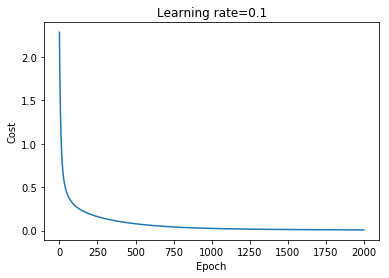

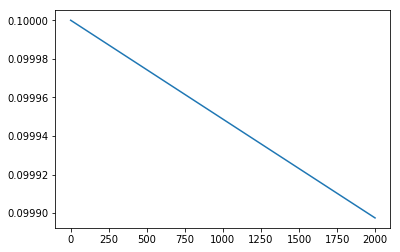

Training accuracy: 97.1333%
Validation accuracy: 90.8000%
Testing accuracy: 91.5000%


In [15]:
learning_rates, prediction, probs, trainingAccuracy, cvAccuracy, testAccuracy = dnnModel(xTrain, convertDummy(yTrain,10), xVal, convertDummy(yVal,10), xTest, yTest , layers, activation_functions, optimizer, learningRate, iterations, batchSize)

In [16]:
ytest = yTest.reshape(len(yTest),1)
predictionfile = np.hstack((ytest+1, prediction+1))
predictionfile = pd.DataFrame(predictionfile, columns=['Actual', 'Predicted'])
predictionfile.to_csv('prediction.csv', index=False)

In [17]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=10

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(convertDummy(ytest,10)[:, i], convertDummy(prediction,10)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

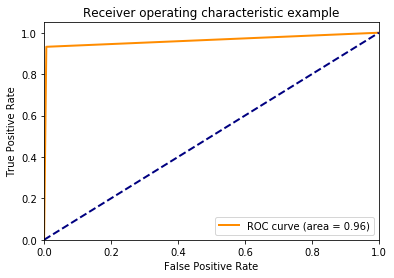

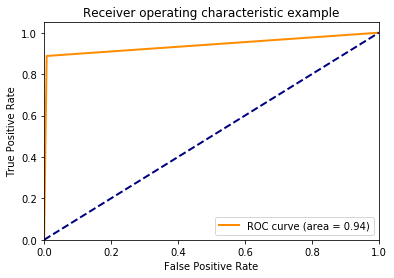

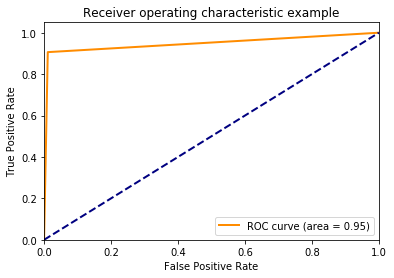

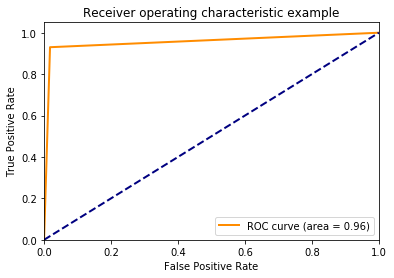

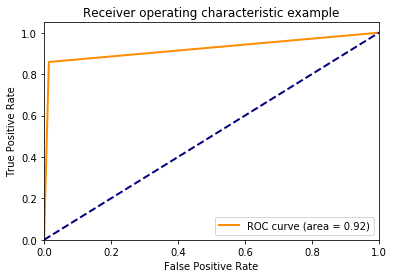

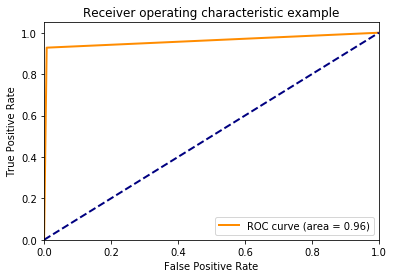

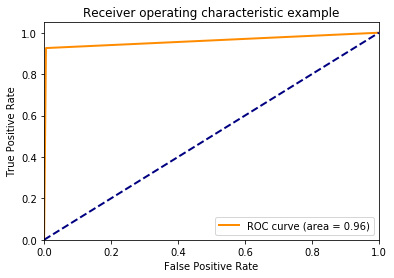

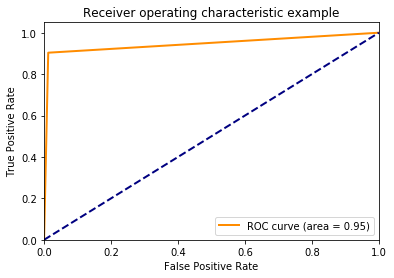

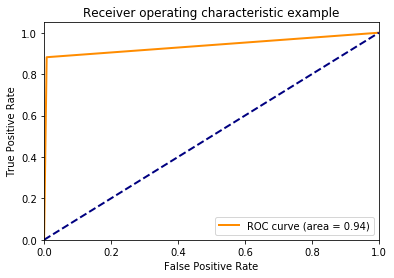

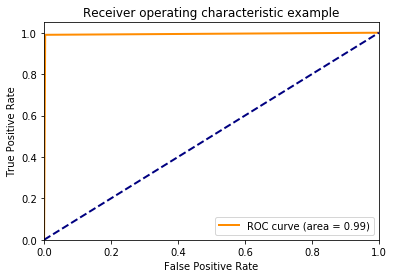

In [18]:
#Plots for each class
for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()